# 6章 機械学習  
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)をダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．  

 1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
 2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
 3. 抽出された事例をランダムに並び替える．
 4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．  

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

df=pd.read_csv('./newsCorpora.csv',header=None,sep='\t',names=['ID','TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP'])
#データの読み込み
#pd.read_csv(元データ,header,sep:区切り,names:区切りごとのタグ付け):csvファイルの読み込みとタグ付け

df=df.loc[df['PUBLISHER'].isin(['Reuters','Huffington Post','Businessweek','Contactmusic.com','Daily Mail']),['TITLE','CATEGORY']]
#データの抽出
#loc[行名,列名]:単独および複数の値を選択、取得・変更
#print(df)

train,valid_test=train_test_split(df,test_size=0.2,shuffle=True,random_state=123,stratify=df['CATEGORY'])
valid,test=train_test_split(valid_test,test_size=0.5,shuffle=True,random_state=123,stratify=valid_test['CATEGORY'])
#データの分割
#sklearn　train,test=train_test_split(df:元データ,test_size:割合,shuffle:シャッフルするか,random_state:乱数シードを指定,stratify:層化抽出):データを訓練用とテスト用に分割
#random_state:乱数シードを固定。固定しないと毎回ランダムに分割される。モデルの性能を比較する場合、分割の仕方によって結果が異なってしまうのでランダムシードを同じに固定する必要がある。
#stratify:均等に分割したいデータを指定するとそのデータの値の比率が一致するように分割される。
#print(train)

train.to_csv('./train.txt',sep='\t',index=False)
valid.to_csv('./valid.txt',sep='\t',index=False)
test.to_csv('./test.txt',sep='\t',index=False)
#ファイルに書き出し(今回はtxtで出力）
#index:行名の有る無し

print('【train】')
print(train['CATEGORY'].value_counts())
print('【valid】')
print(valid['CATEGORY'].value_counts())
print('【test】')
print(test['CATEGORY'].value_counts())

                                                    TITLE CATEGORY
276134  Fitch Lowers South Africa Credit-Rating Outloo...        b
382850  FOREX-Dollar rises on US rate speculation afte...        b
370769  UPDATE 2-Mexico's lower house generally approv...        b
12938   U.S. Navy SEALs take control of North Korean-f...        b
318782  Beyonce - Beyonce And Jay Z Pay Tribute To Mic...        e
...                                                   ...      ...
175007  Fashion Designers Dolce, Gabbana Lose Appeal o...        e
192346  UPDATE 2-Draghi says ECB poised to shore up ec...        b
4495    Bank Austria may sell Ukraine unit within a ye...        b
168520  The Voice's Blake Shelton shares Adam Levine's...        e
242324  Tupac Shakur's Final Words Were 'F**k You,' Ot...        e

[10672 rows x 2 columns]
【train】
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
【valid】
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
【test】
b    563
e   

## 51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう

In [15]:
import string
import re

def preprocessing(text):
    #前処理
    table=str.maketrans(string.punctuation,' '*len(string.punctuation))
    #table=str.maketrans()→text=text.translate(table):文字の変換
    #string.punctuation:句読点として扱われるASCII文字列
    text=text.translate(table)
    #記号をスペースに置換
    text=text.lower()
    #小文字化
    text=re.sub('[0-9]+','0',text)
    #数字列を0に置換
    
    return text

df=pd.concat([train,valid,test],axis=0)
#pd.concat([obj:連結するオブジェクトを指定],axis:連結方向（縦・横）の指定):データを結合
#axis:0→縦、1→横
df.reset_index(drop=True,inplace=True)
#reset_index(drop:元のindexを削除,inplace:元のオブジェクトを変更):インデックスを連番に振り直し

df['TITLE']=df['TITLE'].map(lambda x:preprocessing(x))
#?

print(df['TITLE'].head())

from sklearn.feature_extraction.text import TfidfVectorizer

train_valid=df[:len(train)+len(valid)]
#上で連結したリストは[train+valid+test]の順。このうち:len(train)+len(valid)でtrain+validまでの部分を、len(train)+len(valid):でtestの部分を指定できる。
test=df[len(train)+len(valid):]

vec_tfidf=TfidfVectorizer(min_df=10,ngram_range=(1,2))
#ngram_rangeでTF-IDFを計算する単語の長さを指定
#min_df:使用されている文書の割合、または使用されている文書数がパラメータ以下ならその単語を排除する。あまりにも使用されていない単語を除去できる。

X_train_valid=vec_tfidf.fit_transform(train_valid['TITLE'])
#fit():入力の文書群を与えて語彙の獲得とidfの計算を行う。
#transform():idfから文書をtf-idf行列を作成
#fit_transform():fit()とtransform()を同時に行う。
X_test=vec_tfidf.transform(test['TITLE'])

X_train_valid=pd.DataFrame(X_train_valid.toarray(),columns=vec_tfidf.get_feature_names())
#pd.DataFrame(values,columns:各行名,index:各列名）
#toarray():出力の際にリストの形で出力
#get_feature_names:特徴量名（語彙）を表示する。
X_test=pd.DataFrame(X_test.toarray(),columns=vec_tfidf.get_feature_names())

X_train=X_train_valid[:len(train)]
X_valid=X_train_valid[len(train):]

X_train.to_csv('./train.future.txt',sep='\t',index=False)
X_valid.to_csv('./valid.future.txt',sep='\t',index=False)
X_test.to_csv('./test.futre.txt',sep='\t',index=False)

print(X_train.head())

0    fitch lowers south africa credit rating outloo...
1    forex dollar rises on us rate speculation afte...
2    update 0 mexico s lower house generally approv...
3    u s  navy seals take control of north korean f...
4    beyonce   beyonce and jay z pay tribute to mic...
Name: TITLE, dtype: object
    0d   0m  0nd   0s  0st  0th  0th birthday   aa  abbvie  abc  ...  young  \
0  0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  0.0  ...    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  0.0  ...    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  0.0  ...    0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  0.0  ...    0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  0.0  ...    0.0   

   your  your mother   yr  yr high  yuan  zac  zac efron  zendaya  zone  
0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
1   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
2

## 52. 学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [19]:
from sklearn.linear_model import LogisticRegression

lg=LogisticRegression(random_state=123,max_iter=10000)
#max_iter:学習回数
lg.fit(X_train,train['CATEGORY'])
#X_train:特徴量行列

print("coefficient = ", lg.coef_)
print("intercept = ", lg.intercept_)

coefficient =  [[-0.69078395 -0.02986315  0.26500599 ... -0.57074609 -0.39331912
   0.46384801]
 [-0.27338113  0.4886754  -0.24032157 ...  1.10403159  0.70903827
  -0.47935622]
 [ 0.39878715 -0.10100773 -0.07620882 ... -0.25629878 -0.13860723
   0.06262639]
 [ 0.56537793 -0.35780452  0.0515244  ... -0.27698671 -0.17711192
  -0.04711818]]
intercept =  [ 0.69920576  1.02106104 -1.13275163 -0.58751517]


## 53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [20]:
import numpy as np

def score_lg(lg,X):
    return[np.max(lg.predict_proba(X),axis=1),lg.predict(X)]
#np.max:配列の最大値を取り出す
#lg.predict_proba(X):各データがそれぞれのクラスに所属する確立を返す
#lg.predict(X):Xをlg(ロジスティック回帰モデル）を用いて分類

train_pred=score_lg(lg,X_train)
test_pred=score_lg(lg,X_test)
print(train_pred)

[array([0.9394302 , 0.98281993, 0.61624728, ..., 0.98332608, 0.80166168,
       0.77274288]), array(['b', 'b', 'b', ..., 'b', 'e', 'e'], dtype=object)]


## 54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [21]:
from sklearn.metrics import accuracy_score

train_accuracy=accuracy_score(train['CATEGORY'],train_pred[1])
#acccuracy_sccore():正解率を返す。Accuracy=(TP+TN)/(TP+TN+FP+FN)
test_accuracy=accuracy_score(test['CATEGORY'],test_pred[1])
print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.923
正解率（評価データ）：0.886


## 55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

[[4347   95    7   53]
 [  66 4146    3    8]
 [ 102  134  482   10]
 [ 188  145    8  878]]


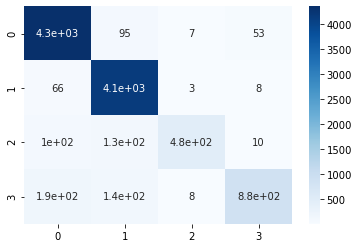

[[533  20   2   8]
 [ 12 513   1   2]
 [ 13  34  39   5]
 [ 28  26   1  97]]


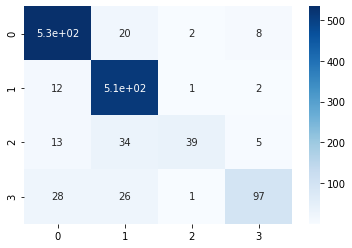

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

train_cm=confusion_matrix(train['CATEGORY'],train_pred[1])
print(train_cm)
sns.heatmap(train_cm,annot=True,cmap='Blues')
plt.show()
#annot:グラフに数値を描画

test_cm=confusion_matrix(test['CATEGORY'],test_pred[1])
print(test_cm)
sns.heatmap(test_cm,annot=True,cmap='Blues')
plt.show()

## 56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

### マイクロ平均とは
**クラスごと**にF1値を計算し、平均したもの
正解率の場合：𝑛𝑖回のテストのうち，𝑥𝑖回が正解の場合，マイクロ平均は次式：
$\frac{\sum_{i=1}^{N} x_i}{\sum_{i=1}^{N} n_i}$

### マクロ平均とは
**全クラス**のF1値を計算したもの
正解率の場合：𝑛𝑖回のテストのうち，𝑥𝑖回が正解の場合，マクロ平均は次式：
$\frac{1}{N}\sum_{i=1}^{N}\frac{x_i}{n_i}$

In [29]:
from sklearn.metrics import precision_score,recall_score,f1_score

def calculate_scores(y_true,y_pred):
    
    #適合率（精度）:precision=TP/(TP+FP)
    precision = precision_score(y_true, y_pred, average=None, labels=['b', 'e', 't', 'm'])  # Noneを指定するとクラスごとの精度をndarrayで返す
    precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))  # 末尾にマイクロ平均を追加
    precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))  # 末尾にマクロ平均を追加
    
    #再現率（検出率）:recall=TP/(TP+FN)
    recall = recall_score(y_true, y_pred, average=None, labels=['b', 'e', 't', 'm'])
    recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
    recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))
    
    #F1スコア:2*(precision*recall)/(precision+recall)
    f1 = f1_score(y_true, y_pred, average=None, labels=['b', 'e', 't', 'm'])
    f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
    f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))
    
    # 結果を結合してデータフレーム化
    scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

    return scores

print(calculate_scores(test['CATEGORY'], test_pred[1]))
    

             適合率       再現率     F1スコア
b       0.909556  0.946714  0.927763
e       0.865093  0.971591  0.915254
t       0.866071  0.638158  0.734848
m       0.906977  0.428571  0.582090
マイクロ平均  0.886057  0.886057  0.886057
マクロ平均   0.886924  0.746259  0.789989


## 57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [27]:
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(lg.classes_, lg.coef_):
    print(f'【カテゴリ】{c}')
    best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
    worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
    display(pd.concat([best10, worst10], axis=0))
    print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,bank,fed,china,ecb,stocks,ukraine,obamacare,euro,oil,yellen
重要度下位,her,video,ebola,the,and,she,aereo,study,google,virus




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,kardashian,chris,star,movie,he,her,she,film,jay,paul
重要度下位,us,update,google,study,gm,china,facebook,billion,ceo,could




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,study,drug,fda,cancer,mers,could,cases,health,cigarettes
重要度下位,facebook,gm,apple,bank,google,ceo,deal,climate,twitter,sales




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,apple,microsoft,climate,gm,tesla,nasa,earth,heartbleed
重要度下位,stocks,fed,her,percent,drug,american,cancer,shares,still,ukraine


## 58. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

## 59. ハイパーパラメータの探索

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．